## crop 적용하지 않고 바로 body contour 딴 거라서 좀 정확도가 떨어집니다.
## 패딩문제 해결됐어요. input, output 둘다 ```1024*1024*3```
## 만약에 input image의 shape이 512나 256인 경우 코드가 좀 망가질 수도 있어요. 픽셀 값이 하드코딩된게 좀 있을거에요

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import matplotlib.image as mpimg


In [2]:
# 여러 이미지 파일 경로를 포함한 리스트
image_paths = [
r"C:\Users\Sese\machinelearning\Lung_Image_AI\data\rapid-cxr-dataset\lung_diseases\Emphysema\00001248_021.png",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\PREPROCESSING\sample\00001754_000.png",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\PREPROCESSING\sample\00028774_025.png",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\PREPROCESSING\sample\CHNCXR_0001_0.png",
r"C:\Users\Sese\machinelearning\Lung_Image_AI\PREPROCESSING\sample\CHNCXR_0171_0.png",
]

In [8]:
import cv2
import numpy as np
from scipy.signal import find_peaks

def calculate_applied_pxl(original_gray):
	# 0. 사전작업
    hist = cv2.calcHist([original_gray], [0], None, [256], [0, 256]).flatten()
    hist_smooth = np.convolve(hist, np.ones(5)/5, mode='same')    
    contrast = np.std(original_gray)
    
    hist_normalized = hist / hist.sum()
    uniformity = -np.sum(hist_normalized * np.log2(hist_normalized + 1e-7))
    
    dark_threshold = np.percentile(original_gray, 30)
    darkness_ratio = np.sum(original_gray <= dark_threshold) / original_gray.size
    
    # 1. 각 요소 정규화
    peaks, _ = find_peaks(hist_smooth, distance=20)
    sorted_peaks = sorted(peaks, key=lambda x: hist_smooth[x], reverse=True)[:2]
    peak_distance = abs(sorted_peaks[0] - sorted_peaks[1])
    contrast_norm = np.clip(contrast / 100, 0, 1)
    uniformity_norm = uniformity / 8
    peak_distance_norm = np.clip(peak_distance / 255, 0, 1)
    
    # 2. 높은 임계값으로 설정할지 낮은 임계값으로 설정할지 결정
    image_score = (contrast_norm * 0.4 + 
                   (1 - uniformity_norm) * 0.3 + 
                   darkness_ratio * 0.3)
    
    hist_sum = np.sum(hist)
    lower_half_ratio = np.sum(hist[:128]) / hist_sum
    upper_half_ratio = np.sum(hist[128:]) / hist_sum
    
    is_high_threshold = (image_score > 0.6) or (upper_half_ratio > 0.6)
    if is_high_threshold:
        threshold_min, threshold_max = 80,130
    else:
        threshold_min, threshold_max = 30,80
    
    # 3. 최종 임계값 계산
    threshold = threshold_min + (threshold_max - threshold_min) * image_score
    applied_pxl = int(threshold)
    
    return applied_pxl

def process_external_contour(processed_img):
    # Part 1: 이미지 전처리 및 픽셀 임계값 계산
    original_gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([original_gray], [0], None, [256], [0, 256])
    applied_pxl = calculate_applied_pxl(original_gray)

    # Part 2: 패딩 추가 및 윤곽선 추출
    # 패딩 추가 (20픽셀씩), 추가된 패딩 이미지에서 그레이스케일 변환
    padding_size = 20
    padded_image = cv2.copyMakeBorder(processed_img, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=0)
    gray_image = cv2.cvtColor(padded_image, cv2.COLOR_BGR2GRAY)
    
    # 임계값 적용하여 바디 마스크 생성
    _, body_mask = cv2.threshold(gray_image, applied_pxl, 255, cv2.THRESH_BINARY)
    
    # 마스크 정제를 위한 모폴로지 연산 (열림과 닫힘 연산)
    kernel = np.ones((5,5), np.uint8)
    body_mask = cv2.morphologyEx(body_mask, cv2.MORPH_CLOSE, kernel, iterations=5)
    body_mask = cv2.morphologyEx(body_mask, cv2.MORPH_OPEN, kernel, iterations=3)
    
    # 외부 윤곽선 찾기
    contours, _ = cv2.findContours(body_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.001 * cv2.arcLength(largest_contour, True)
    smoothed_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Part 3: 패딩 제거 및 최종 결과 이미지 생성
    external_contour_mask_padded = np.zeros(padded_image.shape[:2], dtype=np.uint8)
    cv2.drawContours(external_contour_mask_padded, [smoothed_contour], -1, 255, -1)  # 윤곽선을 채워서 마스크 생성
    external_contour_mask = external_contour_mask_padded[padding_size:-padding_size, padding_size:-padding_size]
    result_image = processed_img.copy()
    cv2.drawContours(result_image, [smoothed_contour - [padding_size, padding_size]], -1, (0, 255, 0), 2)

    return result_image, external_contour_mask, applied_pxl


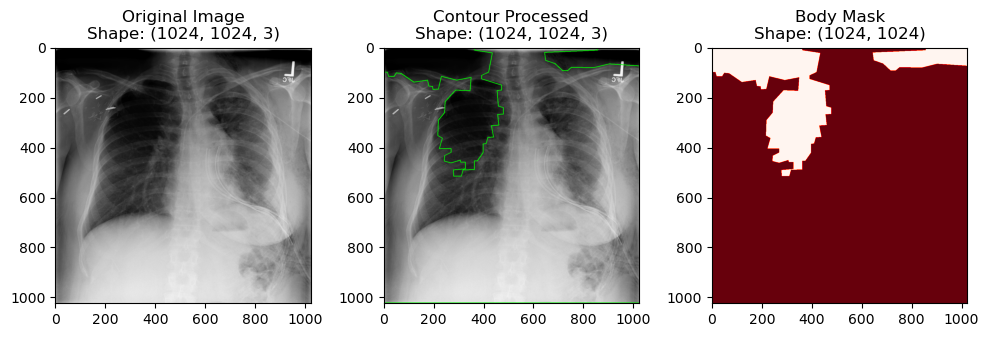

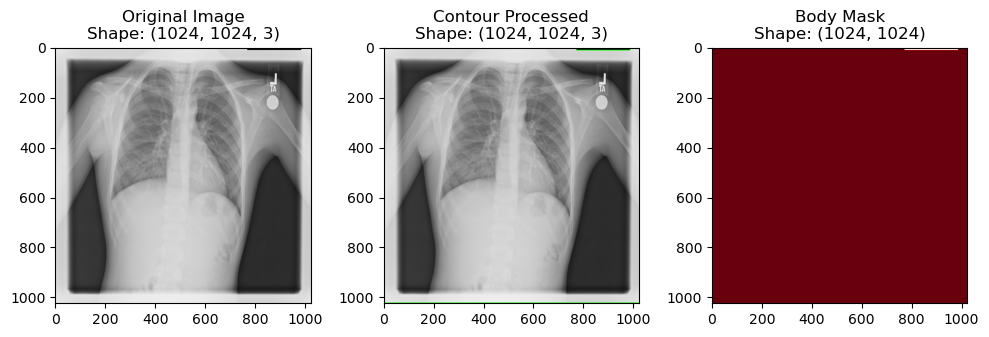

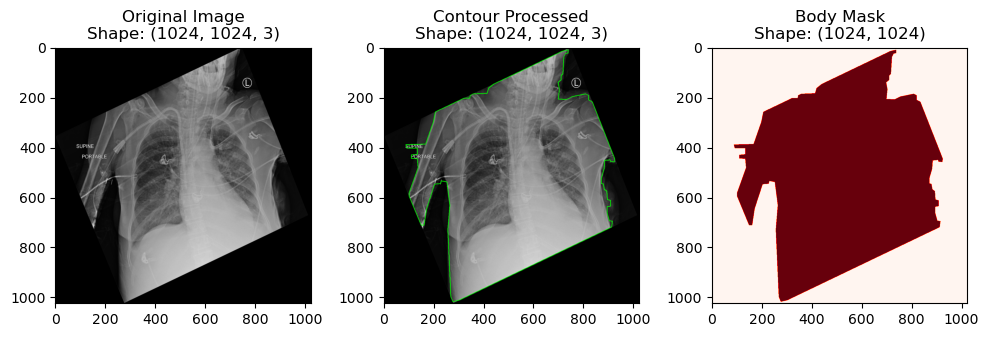

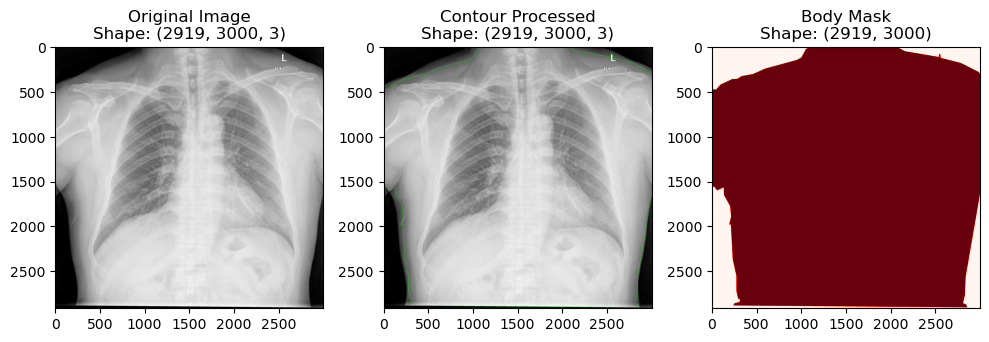

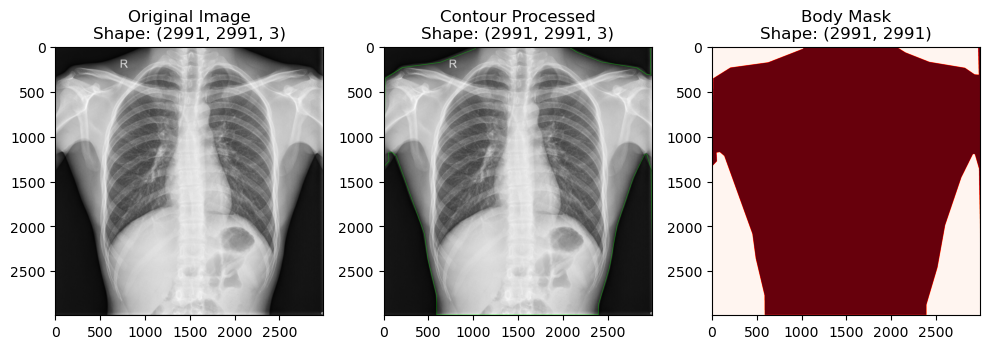

In [18]:
for i in range(5):
	image_original = cv2.imread(image_paths[i])
	img0, body_mask, threshold_pxl = process_external_contour(image_original)

	plt.figure(figsize=(10,5))
	plt.subplot(1, 3, 1)
	plt.imshow(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))
	plt.title(f"Original Image\nShape: {image_original.shape}")
	plt.subplot(1, 3, 2)
	plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
	plt.title(f"Contour Processed\nShape: {img0.shape}")
	plt.subplot(1, 3, 3)
	plt.imshow(body_mask, cmap='Reds')
	plt.title(f"Body Mask\nShape: {body_mask.shape}")

	# 모든 플롯 표시
	plt.tight_layout()
	plt.show()
